In [1]:
### Imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import ImageColorGenerator

In [2]:
pd.set_option("display.max_rows", None)

# Preprocessing of Text for Analysis Purposes

## Import the new dataframe
(that has artist names removed from transcripts)

In [3]:
df = pd.read_json('../raw_data/fully_stripped_df.json')
df.head()

,full_transcript,artist,show_name,year,source,artist_birthday,artist_gender,age_then,full_transcript_clean
0,[rock music playing]\n\n[indistinct chatter]\n...,Adam Devine,Best Time Of Our Lives,2019.0,Scraps from the Loft,1983.0,2,36.0,man let right guy much take seat guy get jacke...
1,"strong language. CHEERING Yes, yes, yes! How...",Adam Hess,Live from the BBC,2016.0,BBC,1990.0,2,26.0,yes yes yes well lovely going apologise state ...
2,"Ladies and gentlemen, please welcome your hos...",Adam Hills,Live at the Apollo Series 9 Episode 4,2013.0,BBC,1970.0,2,43.0,please tonight london london live amazing act ...
3,some strong language and adult humour Ladies...,Adam Hills,Live at the Apollo Series 12 Episode 4,2016.0,BBC,1970.0,2,46.0,please tonight know hair lost bet british para...
4,"? CHEERING Hello, Apollo. I am going to start ...",Adam Hills,Live at the Apollo Series 5 Episode 5,2009.0,BBC,1970.0,2,39.0,going start say something probably never heard...


## LDA model to detect topics

In [ ]:
best_cv_model = CountVectorizer(min_df = 0.4, max_df = 0.8, ngram_range=(1,2))

In [ ]:
#vectorizer = TfidfVectorizer().fit(clean_df['full_transcript_clean'])
vectorizer = best_cv_model

data_vectorized = vectorizer.fit_transform(df['full_transcript_clean'])
lda_model = LatentDirichletAllocation(n_components=30).fit(data_vectorized)

def print_topics(model, vectorizer):
    for idx, topic in enumerate(model.components_):
        print("Topic %d:" % (idx))
        print([(vectorizer.get_feature_names()[i], topic[i])
                        for i in topic.argsort()[:-10 - 1:-1]])
        

print_topics(lda_model, vectorizer)

### Skip for now: Word frequency

In [ ]:
def tokenize(text):
    tokens = word_tokenize(text)
    return tokens

In [ ]:
token_df = df['full_transcript_clean'].apply(tokenize).astype(str)
token_df.head(20)

In [ ]:
pd.Series([y for x in token_df.values.flatten() for y in x.split()]).value_counts().head(50)

## Word cloud

In [46]:
# Selecting the mask for the word clouds
mask = np.array(Image.open('raw_data/emoji.png'))

In [24]:
# instantiate the word cloud
wc = WordCloud(width=1000, height = 1000, background_color='white', max_words = 100,
                       random_state=1, collocations=False, stopwords = STOPWORDS, mask=mask)

In [25]:
# Define a function to plot word cloud
def plot_cloud(wordcloud, mask):
    # Set figure size
    plt.figure(figsize=(30, 20))
    # Display image
    image_colors = ImageColorGenerator(mask)
    plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear") 
    # No axis details
    plt.axis("off");

In [26]:
# Define a function to find index of rows meeting conditions
def get_index(df, option, condition):
    new_dict = {'age': 'age_then', 'gender': 'artist_gender'}
    genders = {'F': '1', 'M': '2', 'Q': '3'}
    
    if option not in ['artist', 'age', 'gender']:
        return 'Options are: artist, age or gender.'
    if type(condition) is not str:
        return 'Please put your condition in a string.'
    
    condition = condition.title()
    
    if option=='gender' and condition not in ['F', 'M', 'Q']:
        return 'Choose from: F(emale), M(ale) or Q(ueer).'
    
    for k, v in new_dict.items():
        option = option.replace(k, v)
    option = option.lower()
    
    if option=='artist':
        output = df[df[option] == condition].index
    else:
        if option=='artist_gender':
            for k, v in genders.items():
                condition = condition.replace(k, v)
        output = df[df[option] == int(condition)].index
    if len(output)<1:
            return f'No results with {option} as {condition}, please check.'
    return output

In [27]:
get_index(df, 'artist', 'bo burnham')

Int64Index([64, 65, 66, 67], dtype='int64')

## Option 1: plot with a dictionary (with LDA output as frequencies)

In [ ]:
def dict_bow(df):
    keys = df.sum().index
    values = df.sum().values
    bow_dict = dict(zip(keys, values))
    return bow_dict

In [ ]:
t = df['full_transcript_clean'][360:362].astype(str)
X = vectorizer.fit_transform(t)
pd.DataFrame(X.toarray(),columns = vectorizer.get_feature_names_out())
# temp_dict = dict_bow(pd.DataFrame(X.toarray(),columns = vectorizer.get_feature_names_out()))
# temp_dict

In [ ]:
def plot_from_bow(df, option, condition, mask, model=best_cv_model):
    index = get_index(df, option, condition)
    start = index[0]
    if index[0] != index[-1]:
        vectorizer = model
    else:
        index = index[0]
        vectorizer = CountVectorizer()
    
    t = df['full_transcript_clean'][index].astype(str)
    X = vectorizer.fit_transform(t)
    temp_dict = dict_bow(pd.DataFrame(X.toarray(),columns = vectorizer.get_feature_names_out()))
    word_cloud = wc.generate_from_frequencies(temp_dict)
    plot_cloud(word_cloud, mask)

In [ ]:
plot_from_bow(df, 'gender', 'f', mask)

## Option 2: plot with string

In [28]:
def plot_decade_cloud(df, decade, mask=None):
    '''
    Input a decade as int
    plot a word cloud for that decade
    '''
    if type(decade)!=int:
        return 'Please input decade value as an int.'
    if decade not in [1960, 1970, 1980, 1990, 2000, 2010, 2020]:
        return 'select a decade from [1960, 1970, 1980, 1990, 2000, 2010, 2020]'
    decade_df = df[(df.year//10)*10 == decade]
    
    t = decade_df['full_transcript_clean']
    selection = ' '.join(t)
    print(f"Plotting with transcripts of {len(selection)} characters...")
    word_cloud = wc.generate(selection)
    print(f'Here is a word cloud of transcripts from the {decade}s.')
    plot_cloud(word_cloud, mask)

Plotting with transcripts of 1094942 characters...
Here is a word cloud of transcripts from the 2000s.


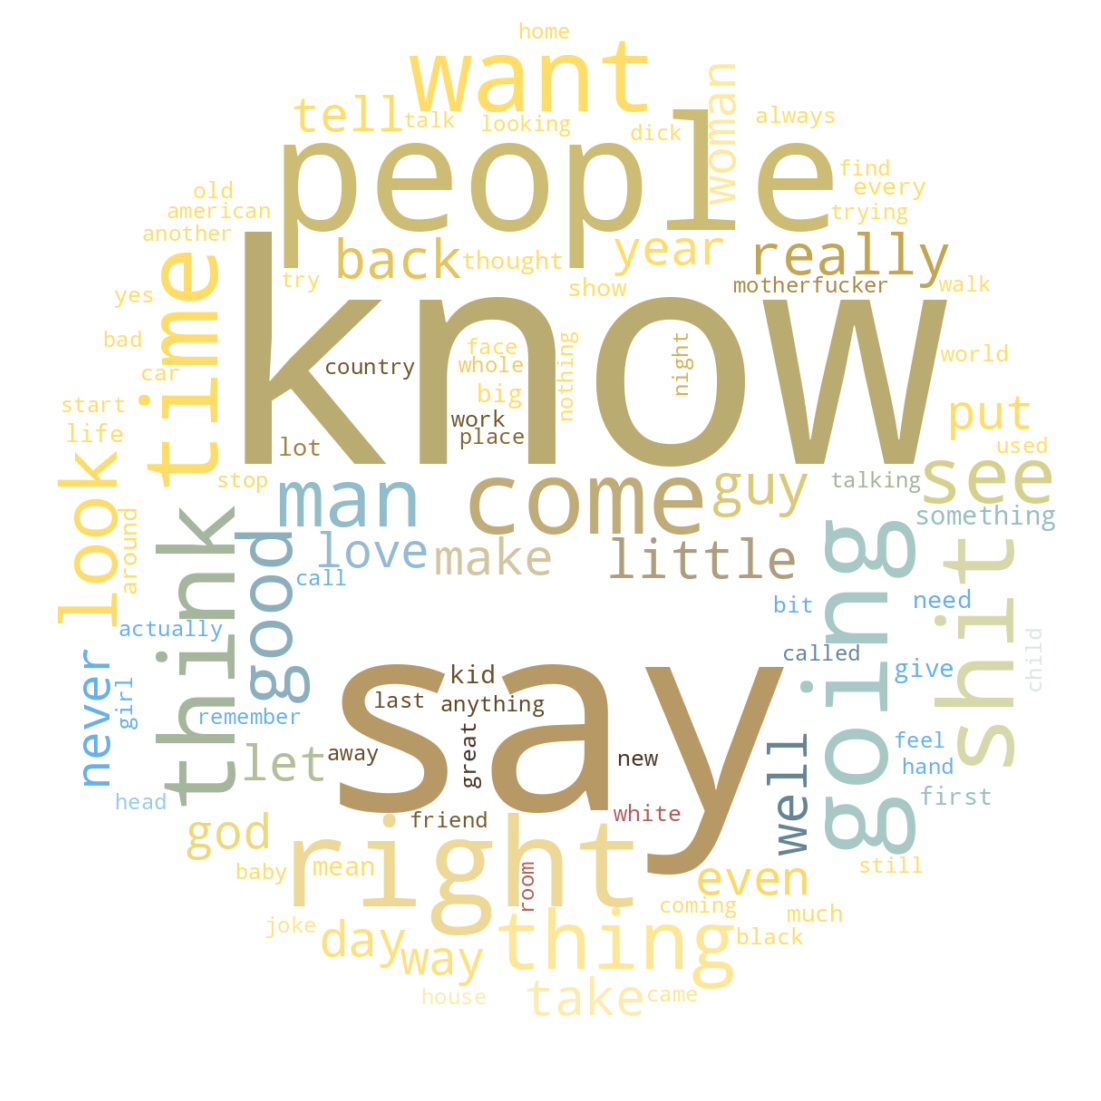

In [49]:
# Example

plot_decade_cloud(df, 2000, mask)

In [55]:
def plot_some_cloud(df, option, condition, mask=None):
    '''
    search for index meeting conditions
    plot a word cloud
    '''
    
    index = get_index(df, option, condition)
    if index[0] == index[-1]:
        index = index[0]
        selection = df['full_transcript_clean'][index]
    else:
        t = df['full_transcript_clean'][index]
        selection = ' '.join(t)
    
    no_of_transcripts = index[-1]-index[0]+1
    
    print(f'{no_of_transcripts} transcripts found.')
    print(f"Plotting with transcripts of {len(selection)} characters...")
    word_cloud = wc.generate(selection)
    plot_cloud(word_cloud, mask)

4 transcripts found.
Plotting with transcripts of 77231 characters...


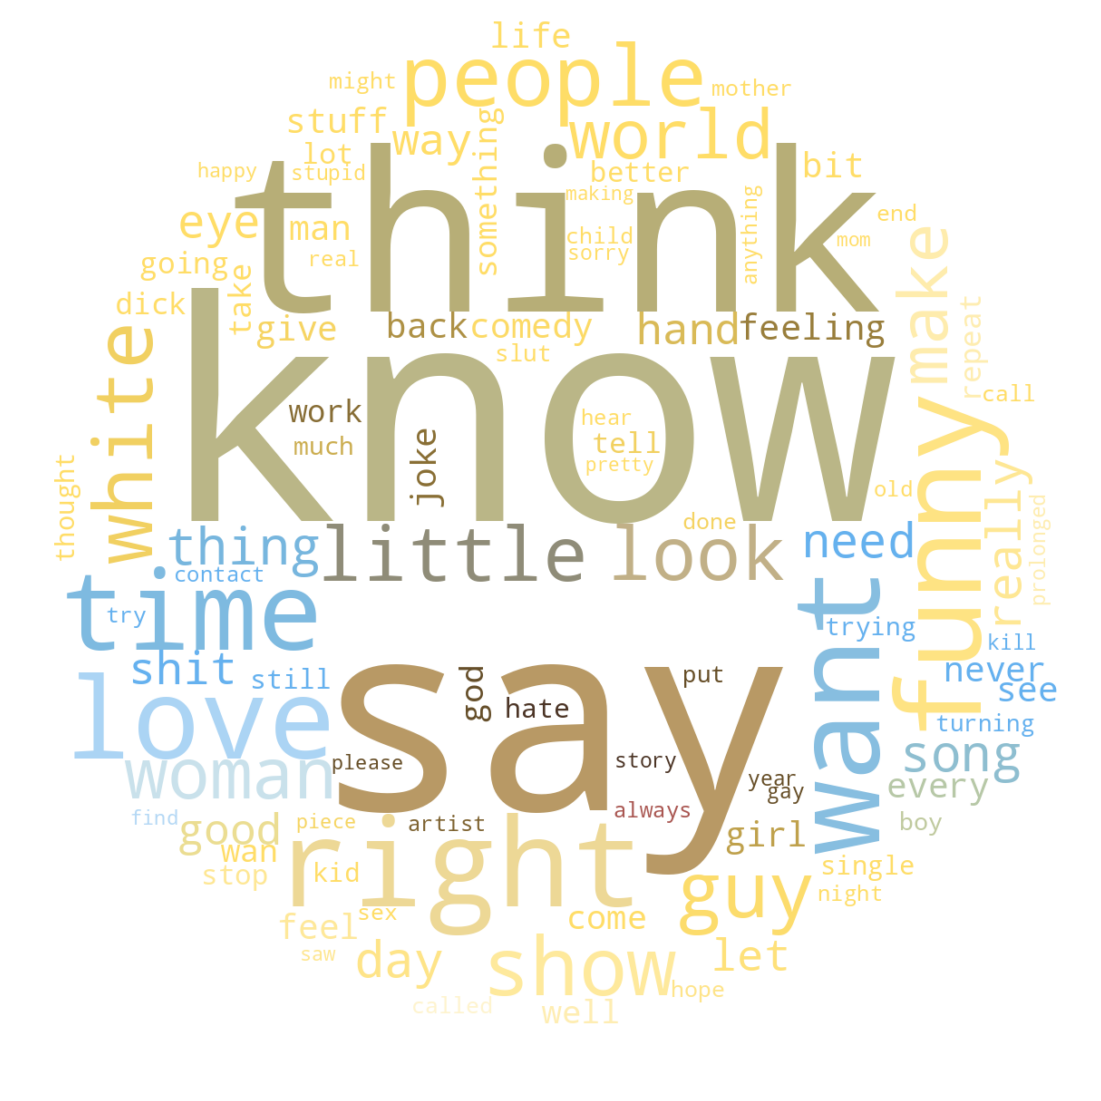

In [56]:
# example
plot_some_cloud(df, 'artist', 'bo burnham', mask)